C:\Users\jorda\AppData\Local\Temp\ipykernel_21408\2305581954.py:78: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  state_data_rahil = state_data_rahil.groupby('VOLUNTEER', group_keys=False).apply(subtract_baseline, state=state)
C:\Users\jorda\AppData\Local\Temp\ipykernel_21408\2305581954.py:78: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  state_data_rahil = state_data_rahil.groupby('VOLUNTEER', group_keys=F

Error: Missing baseline value for volunteer 107 in state CD8TE.


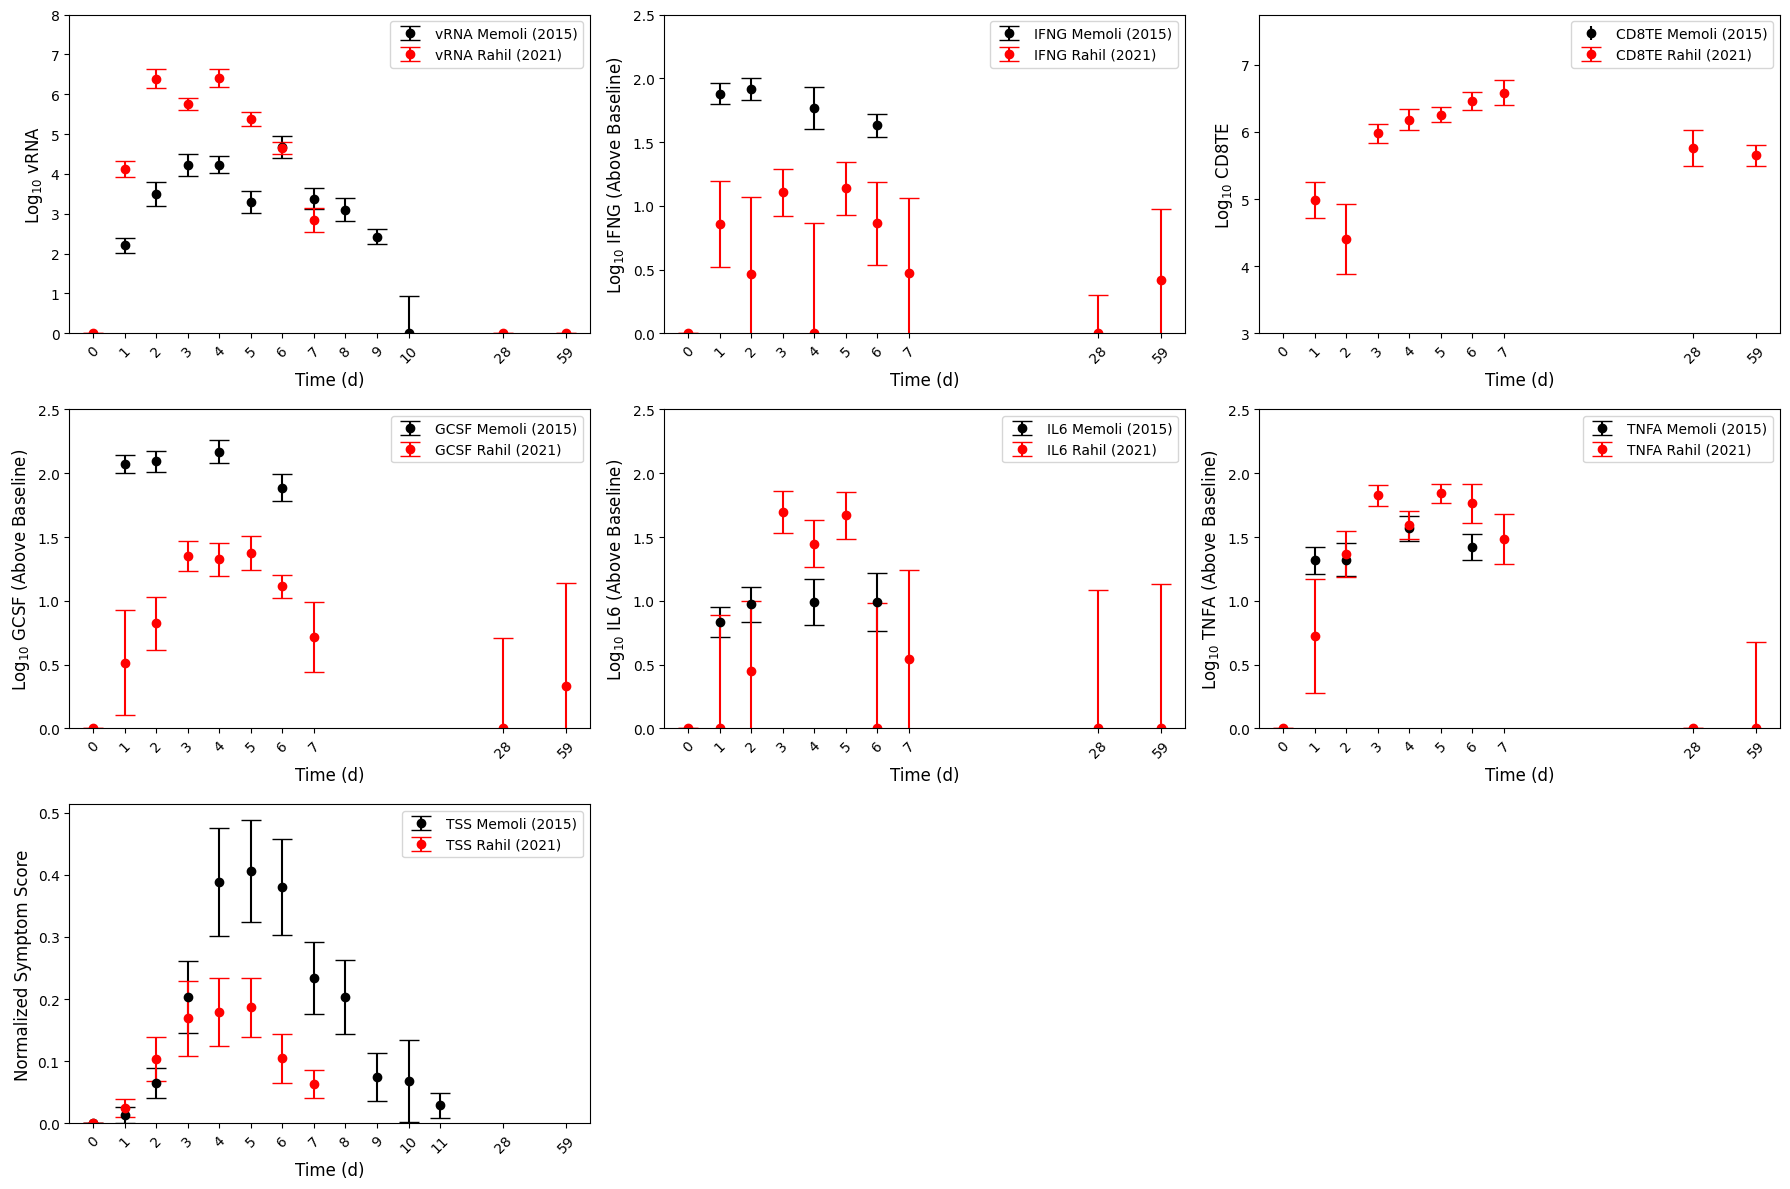

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# Load Memoli data
df_Memoli2015 = pd.read_excel('../Data/Memoli2015.xlsx')
df_Memoli2015.columns = ["DAY", "State", "Metric", "Value", "Error Metric", "Error Value", "Unit"]

# Load Rahil data
df_Rahil = pd.read_excel("../Data/Rahil_2020/Table8_Healed.xlsx", sheet_name='NoTail', usecols=list(range(0, 143)))
df_Rahil = df_Rahil[['VOLUNTEER', 'DAY', 'V', 'IFNG', 'CD8TE', 'GCSF', 'IL6', 'TNFA', 'TSS']]
df_Rahil = df_Rahil.loc[(df_Rahil['DAY'] >= 0) & (df_Rahil['DAY'] < 60)]
shedders = [103, 107, 110, 111, 112, 204, 207, 302, 307, 308, 311, 312]
df_Rahil = df_Rahil[df_Rahil['VOLUNTEER'].isin(shedders)]
df_Rahil.rename(columns={'V': 'vRNA'}, inplace=True)

# Define states to plot
states_to_plot = ['vRNA', 'IFNG', 'CD8TE', 'GCSF', 'IL6', 'TNFA', 'TSS']
log_states = ["GCSF", "IFNG", "IL6", "TNFA", "vRNA", "CD8TE"]
cytokines = ["GCSF", "IFNG", "IL6", "TNFA"]
states = ['vRNA', 'IFNG', 'CD8TE', 'GCSF', 'IL6', 'TNFA', 'TSS']
y_limits = {
    "CD8TE": (3, 7.75),
    "GCSF": (0, 2.5),
    "IFNG": (0, 2.5),
    "IL6": (0, 2.5),
    "TNFA": (0, 2.5),
    "vRNA": (0, 8),
}

def log10_floor(value):
    return np.log10(np.maximum(value, 1))

# Collect all days with data across all states
all_days_with_data = set()
for state in states_to_plot:
    days_with_data_memoli = df_Memoli2015[df_Memoli2015['State'] == state]['DAY'].unique()
    days_with_data_rahil = df_Rahil[['DAY', state]].dropna(subset=[state])['DAY'].unique()
    all_days_with_data.update(days_with_data_memoli)
    all_days_with_data.update(days_with_data_rahil)
all_days_with_data = sorted(all_days_with_data)

# Adjust x positions for gaps in days
x_positions = []
x_pos = 0
x_positions.append(x_pos)
for i in range(1, len(all_days_with_data)):
    gap = all_days_with_data[i] - all_days_with_data[i - 1]
    if gap <= 10:
        x_pos += 1
    else:
        x_pos += 2
    x_positions.append(x_pos)
day_to_xpos = dict(zip(all_days_with_data, x_positions))

def subtract_baseline(group, state):
    baseline_value = group.loc[group['DAY'] == 0, state]
    if baseline_value.empty:
        print(f"Error: Missing baseline value for volunteer {group['VOLUNTEER'].iloc[0]} in state {state}.")
        return group  # Return the group without modification
    baseline = baseline_value.iloc[0]
    group[state] = group[state] - baseline
    return group

# Create subplots
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
axs = axs.flatten()

for idx, state in enumerate(states_to_plot):
    ax = axs[idx]
    # Prepare Memoli data
    state_data_memoli = df_Memoli2015[df_Memoli2015['State'] == state].copy()
    # Prepare Rahil data
    state_data_rahil = df_Rahil[['VOLUNTEER', 'DAY', state]].copy()
    state_data_rahil = state_data_rahil.dropna(subset=[state])
    # Adjust baseline for Rahil data
    state_data_rahil = state_data_rahil.groupby('VOLUNTEER', group_keys=False).apply(subtract_baseline, state=state)
    state_data_rahil = state_data_rahil.dropna(subset=[state])  # Remove rows with missing baseline adjustments
    # Calculate Rahil mean and SEM
    rahil_mean = state_data_rahil.groupby('DAY')[state].mean()
    rahil_sem = state_data_rahil.groupby('DAY')[state].sem()
    # Map days to x positions
    state_data_memoli['xpos'] = state_data_memoli['DAY'].map(day_to_xpos)
    state_data_rahil['xpos'] = state_data_rahil['DAY'].map(day_to_xpos)
    rahil_mean_xpos = [day_to_xpos[day] for day in rahil_mean.index]
    # Plot Memoli data
    if state in log_states:
        state_data_memoli.loc[:, 'Log Value'] = log10_floor(state_data_memoli['Value'])
        upper_error = state_data_memoli['Value'] + state_data_memoli['Error Value']
        state_data_memoli.loc[:, 'Log Error'] = log10_floor(upper_error) - state_data_memoli['Log Value']
        ax.errorbar(
            state_data_memoli['xpos'],
            state_data_memoli['Log Value'],
            yerr=state_data_memoli['Log Error'],
            fmt='o',
            capsize=7,
            label=f"{state} Memoli (2015)",
            color='black'
        )
    else:
        ax.errorbar(
            state_data_memoli['xpos'],
            state_data_memoli['Value'],
            yerr=state_data_memoli['Error Value'],
            fmt='o',
            capsize=7,
            label=f"{state} Memoli (2015)",
            color='black'
        )
    # Plot Rahil data
    if state in log_states:
        rahil_mean_log = log10_floor(rahil_mean)
        rahil_upper_log = log10_floor(rahil_mean + rahil_sem)
        rahil_sem_log = rahil_upper_log - rahil_mean_log
        ax.errorbar(
            rahil_mean_xpos,
            rahil_mean_log,
            yerr=rahil_sem_log,
            fmt='o',
            capsize=7,
            label=f"{state} Rahil (2021)",
            color='red'
        )
    else:
        ax.errorbar(
            rahil_mean_xpos,
            rahil_mean,
            yerr=rahil_sem,
            fmt='o',
            capsize=7,
            label=f"{state} Rahil (2021)",
            color='red'
        )
    
    # Finalize plot
    ax.set_xlabel("Time (d)", fontsize=12)
    if state in log_states:
        ylabstr = r"$\mathrm{Log}_{10}$ " + state 
        if state in cytokines:
            ylabstr += " (Above Baseline)" 
    else:
        ylabstr = 'Normalized Symptom Score'
    ax.set_ylabel(ylabstr, fontsize=12)
    ax.legend(fontsize=10)
    
    days_with_data_in_subplot = sorted(set(state_data_memoli['DAY'].unique()).union(state_data_rahil['DAY'].unique()))
    x_positions_in_subplot = [day_to_xpos[day] for day in days_with_data_in_subplot]
    ax.set_xticks(x_positions_in_subplot)
    ax.set_xticklabels(days_with_data_in_subplot, rotation=45)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.grid(False)
    ylim = y_limits.get(state, (0, None))
    ax.set_ylim(ylim)
    
for idx in range(len(states_to_plot), len(axs)):
    fig.delaxes(axs[idx])


plt.tight_layout()
plt.show()


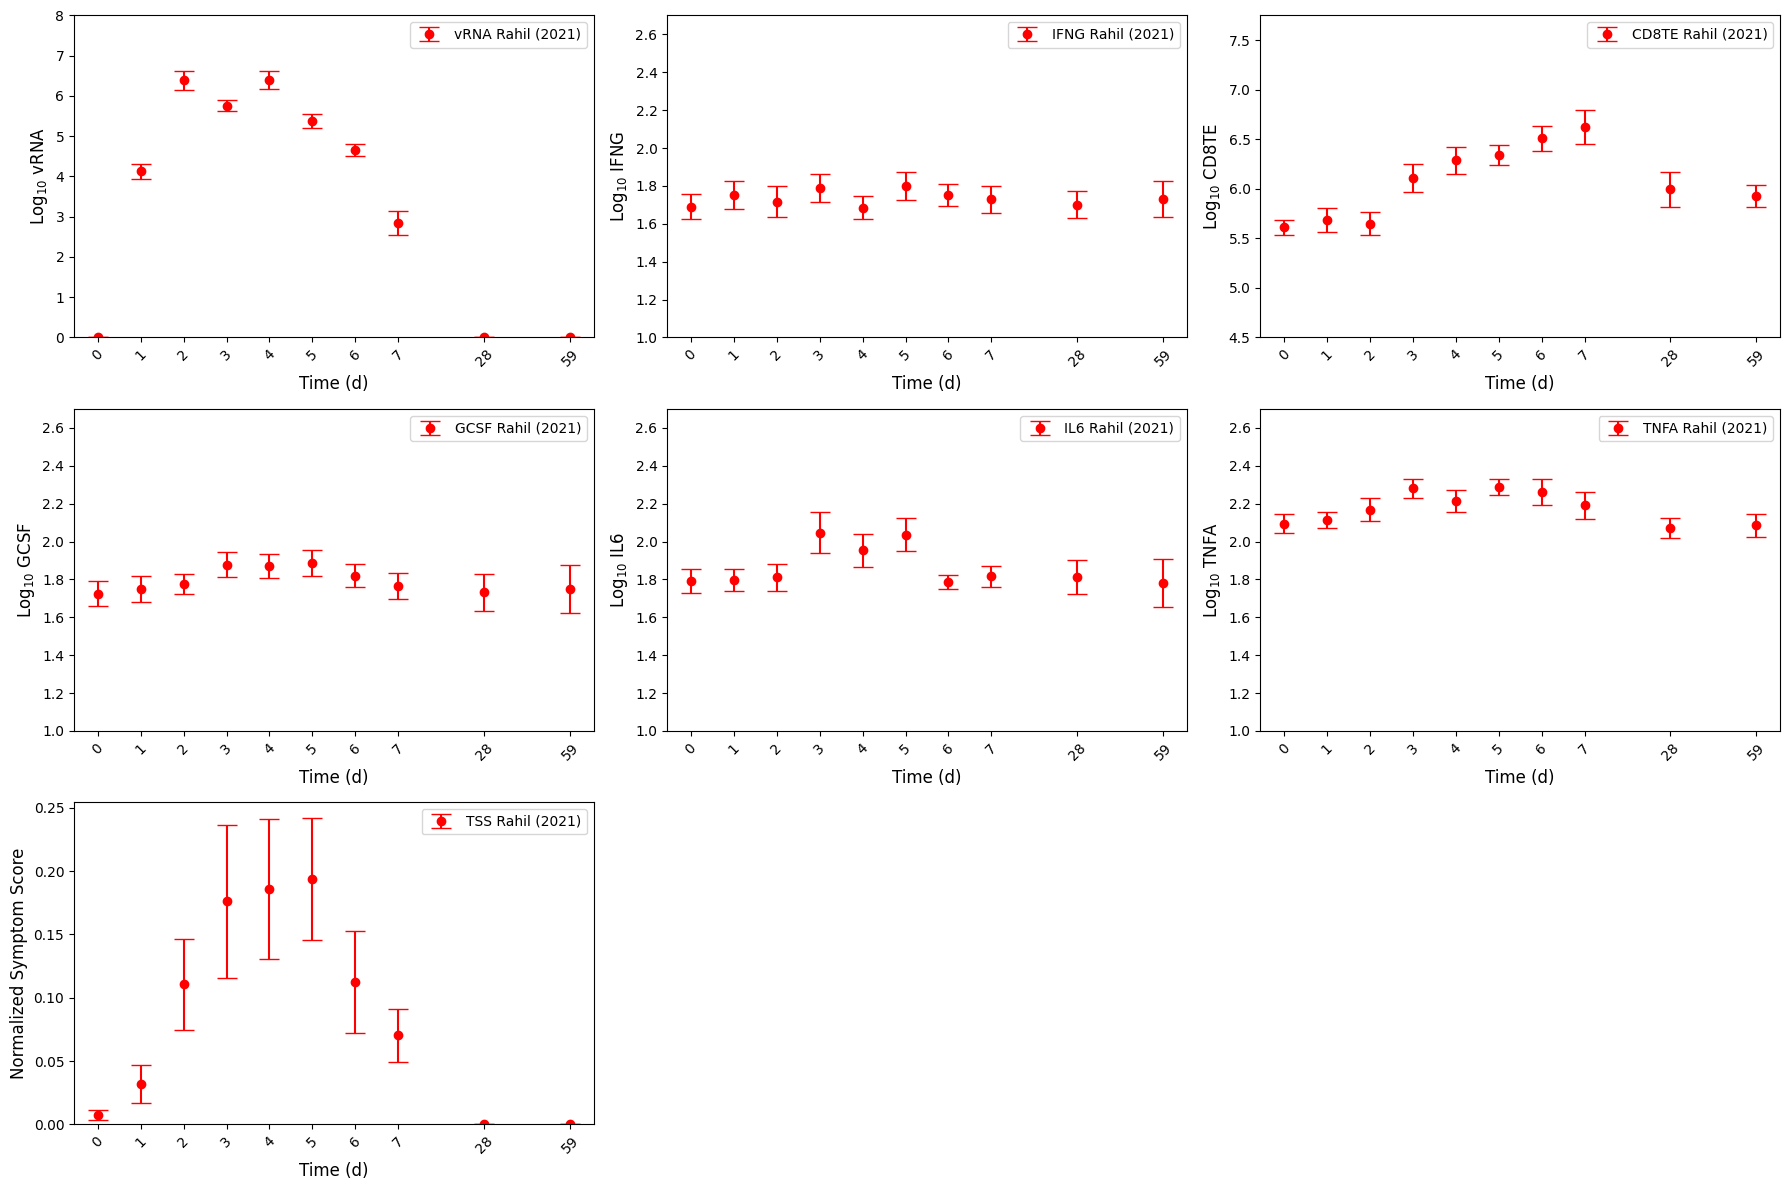

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# Load Rahil data
df_Rahil = pd.read_excel("../Data/Rahil_2020/Table8_Healed.xlsx", sheet_name='NoTail', usecols=list(range(0, 143)))
df_Rahil = df_Rahil[['VOLUNTEER', 'DAY', 'V', 'IFNG', 'CD8TE', 'GCSF', 'IL6', 'TNFA', 'TSS']]
df_Rahil = df_Rahil.loc[(df_Rahil['DAY'] >= 0) & (df_Rahil['DAY'] < 60)]
shedders = [103, 107, 110, 111, 112, 204, 207, 302, 307, 308, 311, 312]
df_Rahil = df_Rahil[df_Rahil['VOLUNTEER'].isin(shedders)]
df_Rahil.rename(columns={'V': 'vRNA'}, inplace=True)

# Define states to plot
states_to_plot = ['vRNA', 'IFNG', 'CD8TE', 'GCSF', 'IL6', 'TNFA', 'TSS']
log_states = ["GCSF", "IFNG", "IL6", "TNFA", "vRNA", "CD8TE"]
cytokines = ["GCSF", "IFNG", "IL6", "TNFA"]
states = ['vRNA', 'IFNG', 'CD8TE', 'GCSF', 'IL6', 'TNFA', 'TSS']
y_limits = {
    "CD8TE": (4.5, 7.75),
    "GCSF": (1, 2.7),
    "IFNG": (1, 2.7),
    "IL6": (1, 2.7),
    "TNFA": (1, 2.7),
    "vRNA": (0, 8),
}

def log10_floor(value):
    return np.log10(np.maximum(value, 1))

# Collect all days with data across all states
all_days_with_data = set()
for state in states_to_plot:
    days_with_data_rahil = df_Rahil[['DAY', state]].dropna(subset=[state])['DAY'].unique()
    all_days_with_data.update(days_with_data_rahil)
all_days_with_data = sorted(all_days_with_data)

# Adjust x positions for gaps in days
x_positions = []
x_pos = 0
x_positions.append(x_pos)
for i in range(1, len(all_days_with_data)):
    gap = all_days_with_data[i] - all_days_with_data[i - 1]
    if gap <= 10:
        x_pos += 1
    else:
        x_pos += 2
    x_positions.append(x_pos)
day_to_xpos = dict(zip(all_days_with_data, x_positions))

# Create subplots
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
axs = axs.flatten()
for idx, state in enumerate(states_to_plot):
    ax = axs[idx]
    # Prepare Rahil data
    state_data_rahil = df_Rahil[['VOLUNTEER', 'DAY', state]].copy()
    state_data_rahil = state_data_rahil.dropna(subset=[state])
    # Calculate Rahil mean and SEM
    rahil_mean = state_data_rahil.groupby('DAY')[state].mean()
    rahil_sem = state_data_rahil.groupby('DAY')[state].sem()
    # Map days to x positions
    state_data_rahil['xpos'] = state_data_rahil['DAY'].map(day_to_xpos)
    rahil_mean_xpos = [day_to_xpos[day] for day in rahil_mean.index]
    # Plot Rahil data
    if state in log_states:
        rahil_mean_log = log10_floor(rahil_mean)
        rahil_upper_log = log10_floor(rahil_mean + rahil_sem)
        rahil_sem_log = rahil_upper_log - rahil_mean_log
        ax.errorbar(
            rahil_mean_xpos,
            rahil_mean_log,
            yerr=rahil_sem_log,
            fmt='o',
            capsize=7,
            label=f"{state} Rahil (2021)",
            color='red'
        )
    else:
        ax.errorbar(
            rahil_mean_xpos,
            rahil_mean,
            yerr=rahil_sem,
            fmt='o',
            capsize=7,
            label=f"{state} Rahil (2021)",
            color='red'
        )
    
    # Finalize plot
    ax.set_xlabel("Time (d)", fontsize=12)
    if state in log_states:
        ylabstr = r"$\mathrm{Log}_{10}$ " + state 
    else:
        ylabstr = 'Normalized Symptom Score'
    ax.set_ylabel(ylabstr, fontsize=12)
    ax.legend(fontsize=10)
    
    days_with_data_in_subplot = sorted(set(state_data_rahil['DAY'].unique()))
    x_positions_in_subplot = [day_to_xpos[day] for day in days_with_data_in_subplot]
    ax.set_xticks(x_positions_in_subplot)
    ax.set_xticklabels(days_with_data_in_subplot, rotation=45)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.grid(False)
    ylim = y_limits.get(state, (0, None))
    ax.set_ylim(ylim)
    
for idx in range(len(states_to_plot), len(axs)):
    fig.delaxes(axs[idx])
plt.tight_layout()
plt.show()


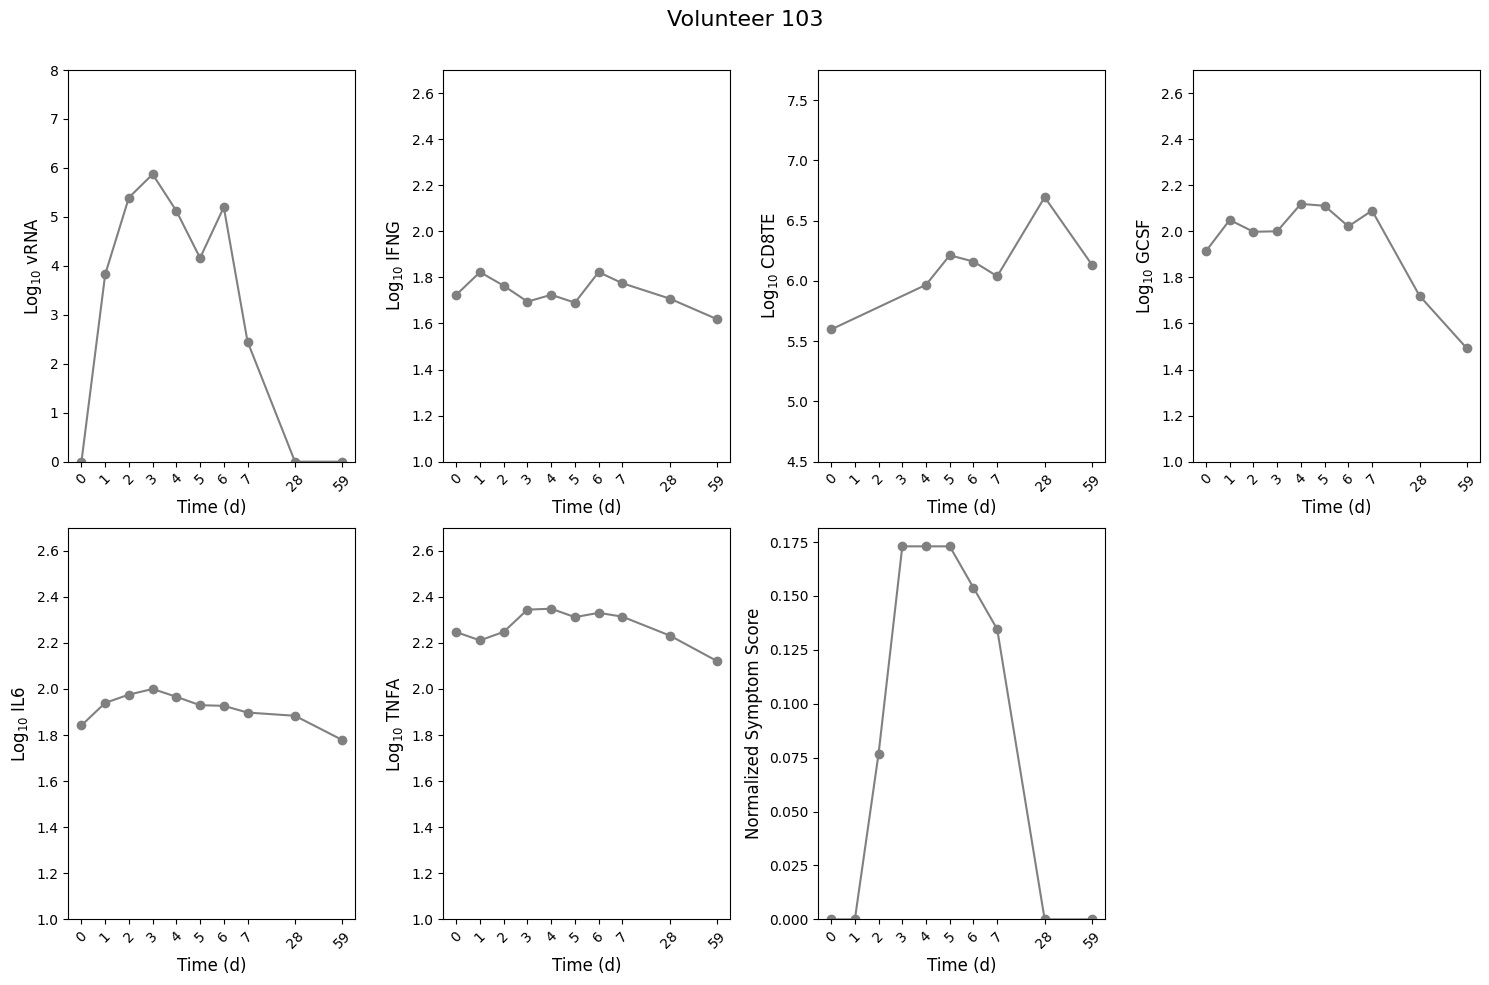

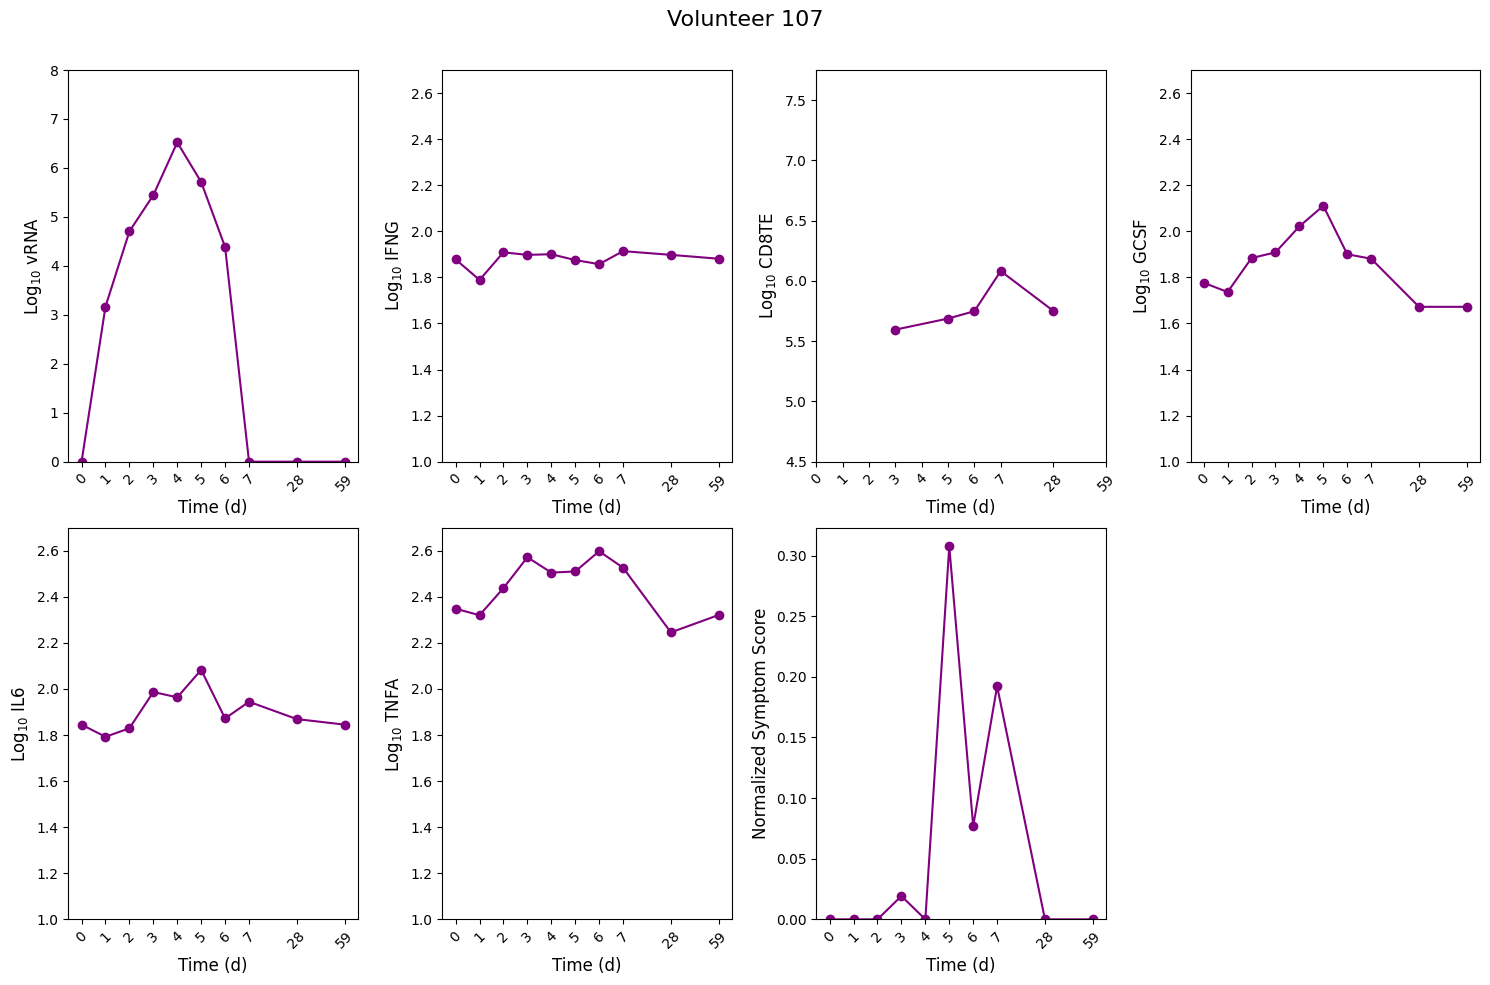

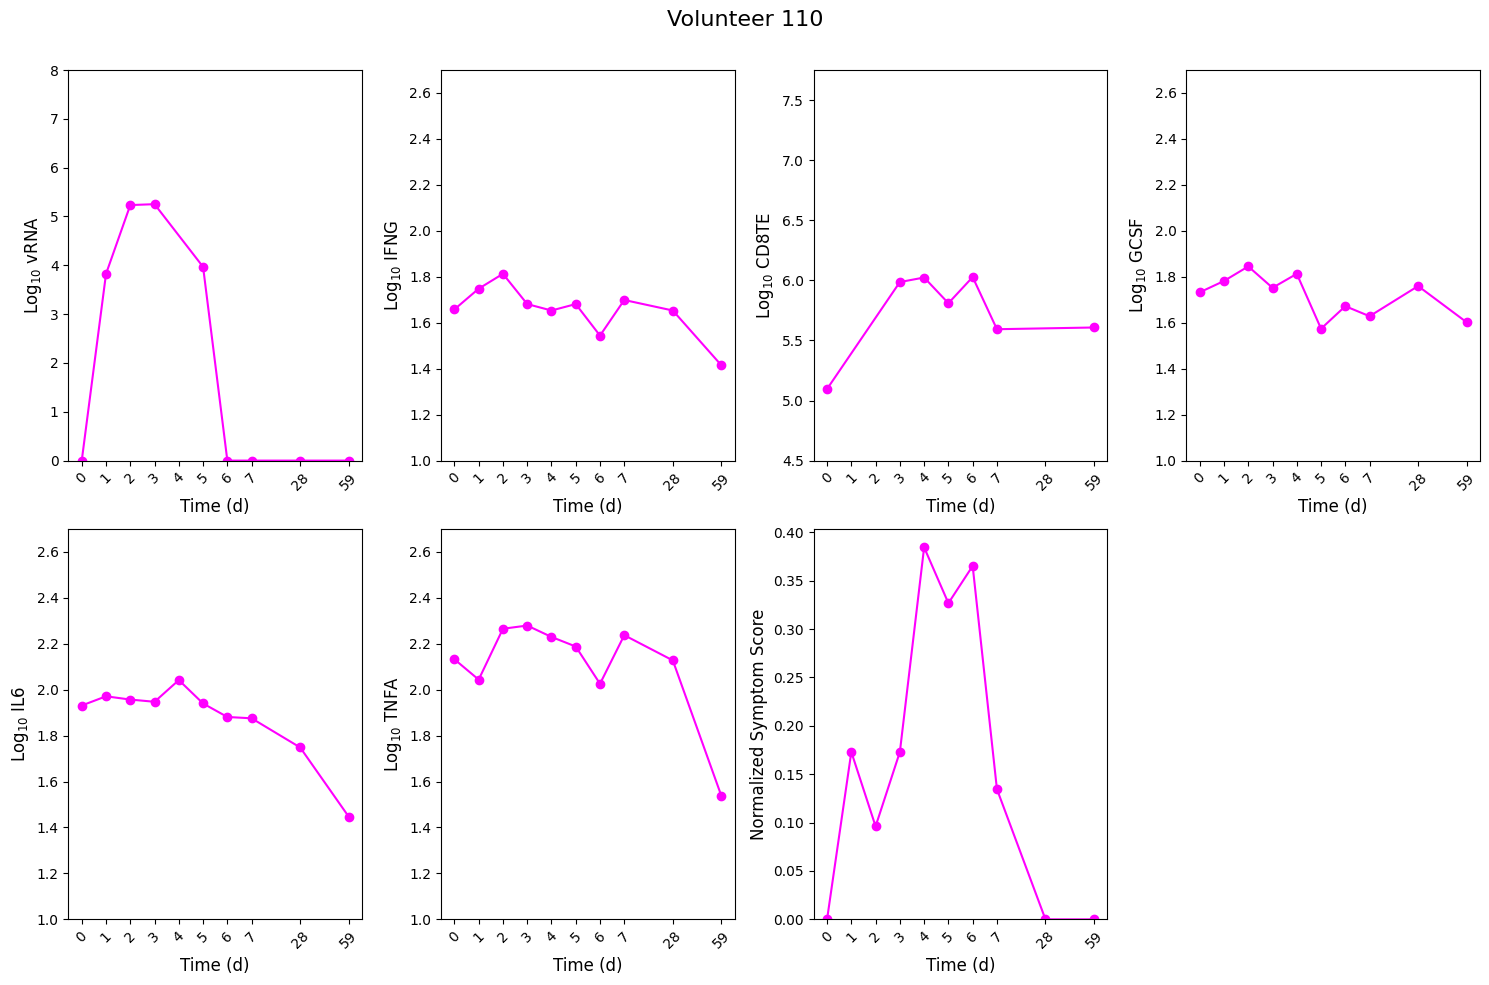

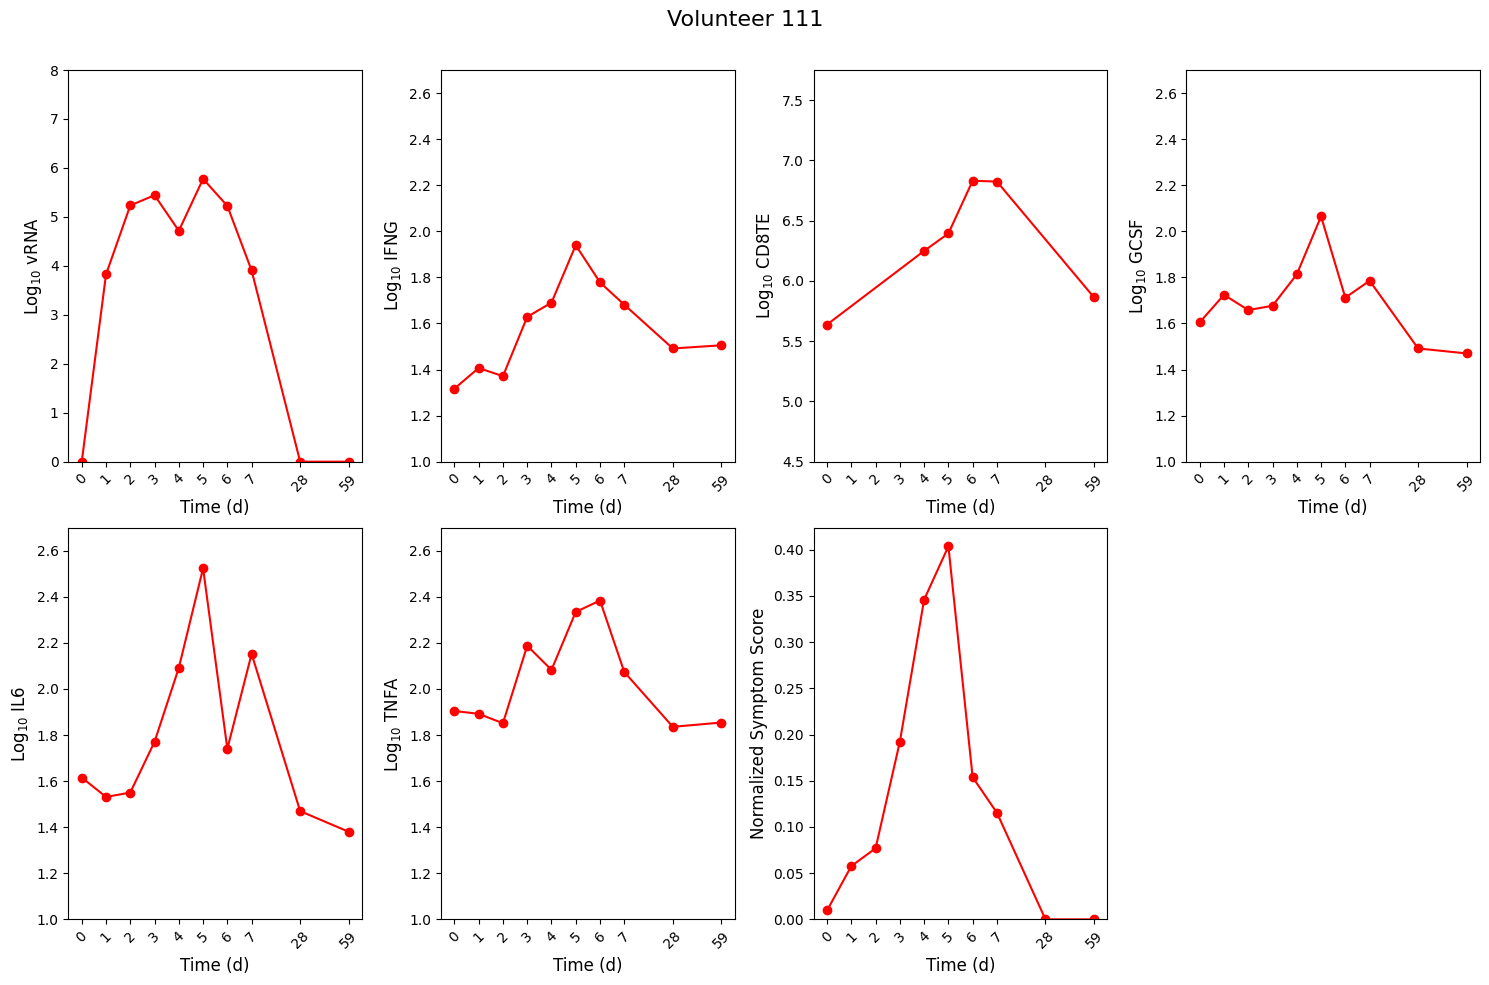

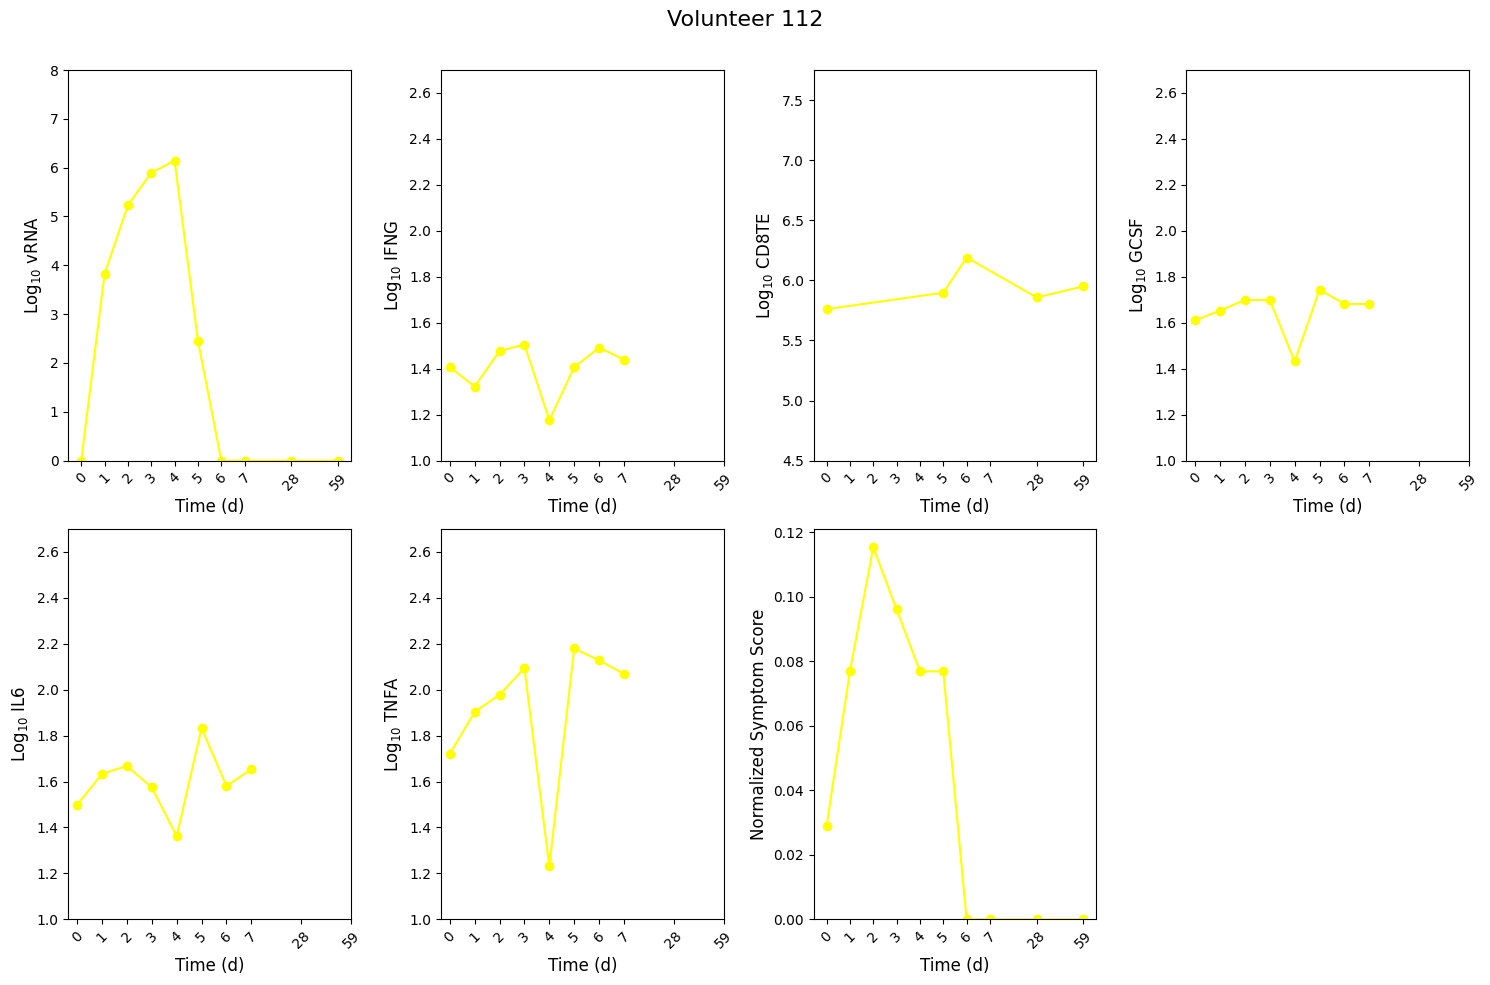

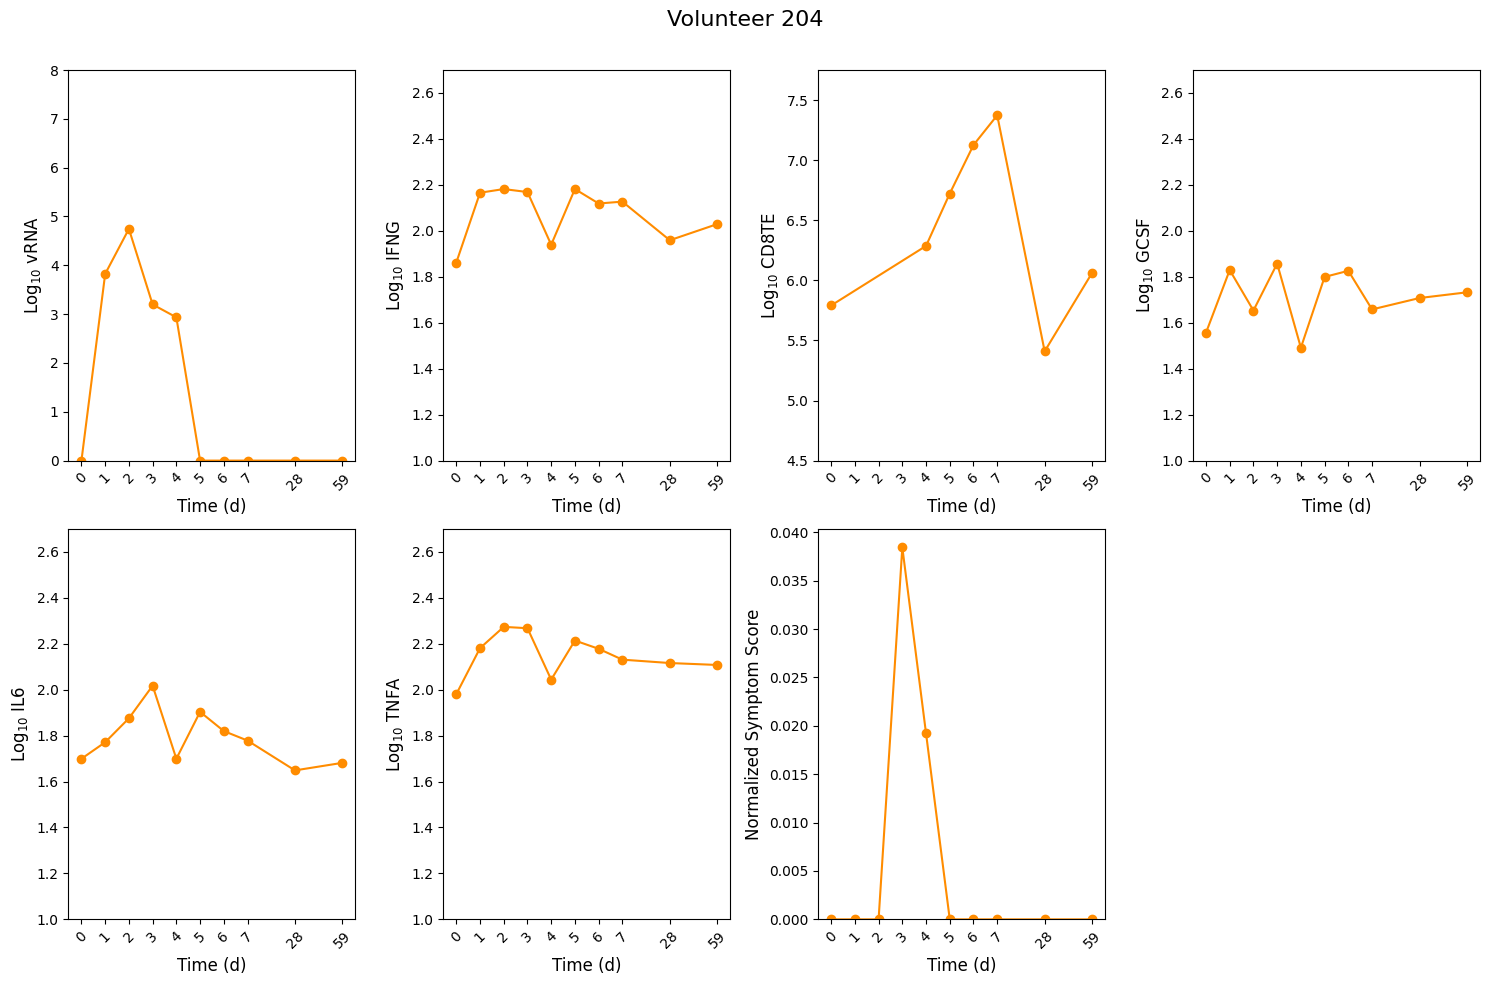

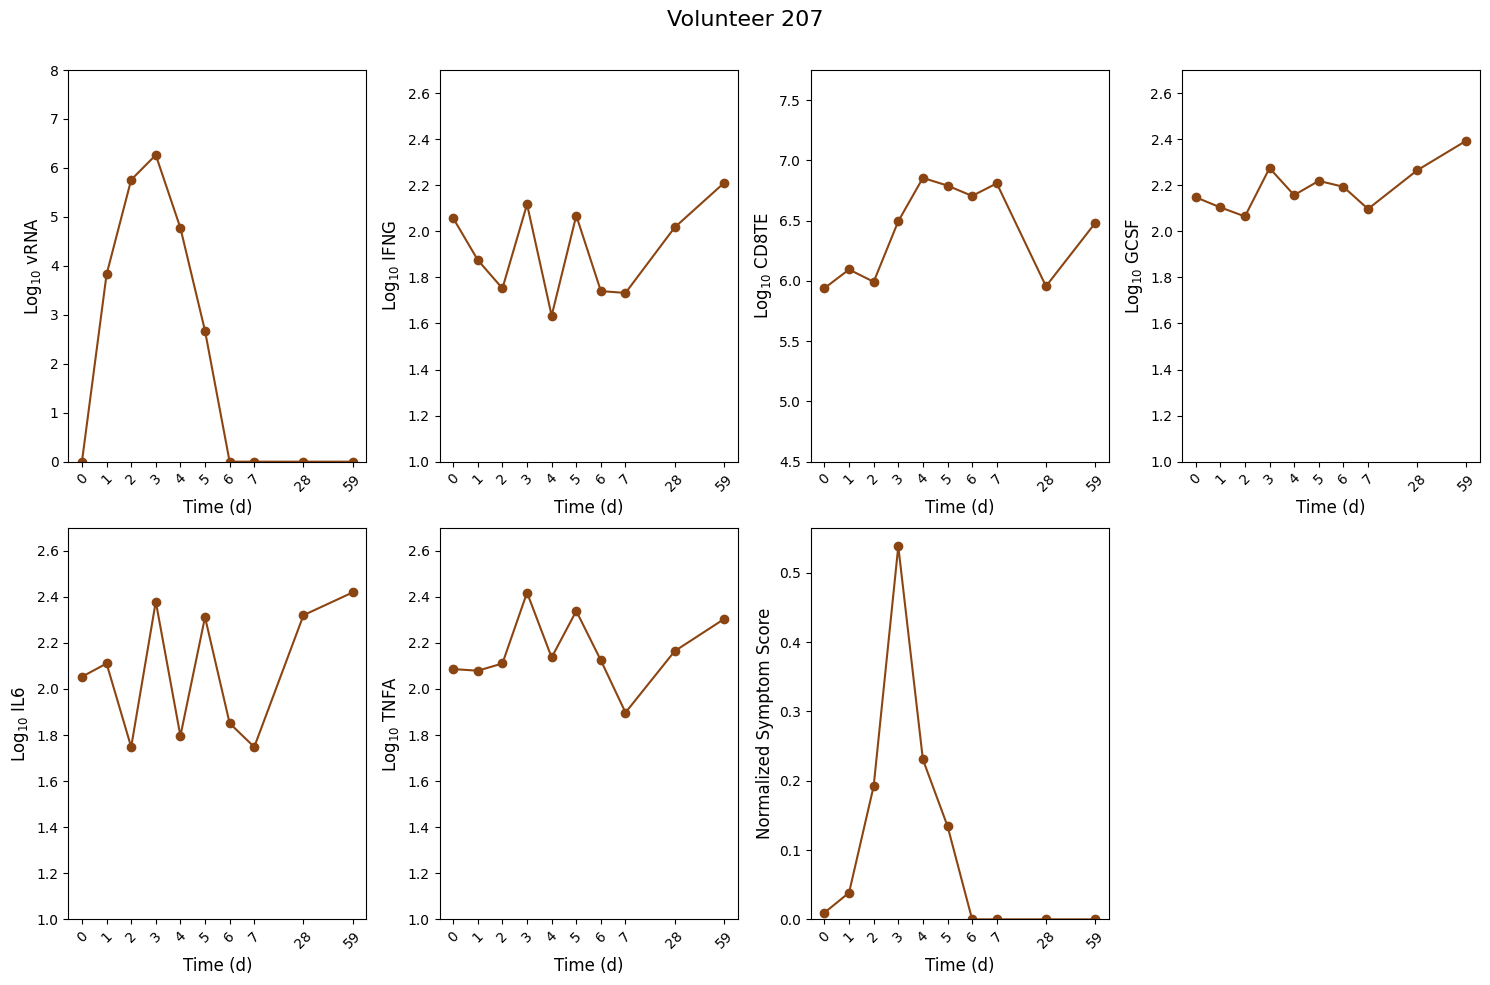

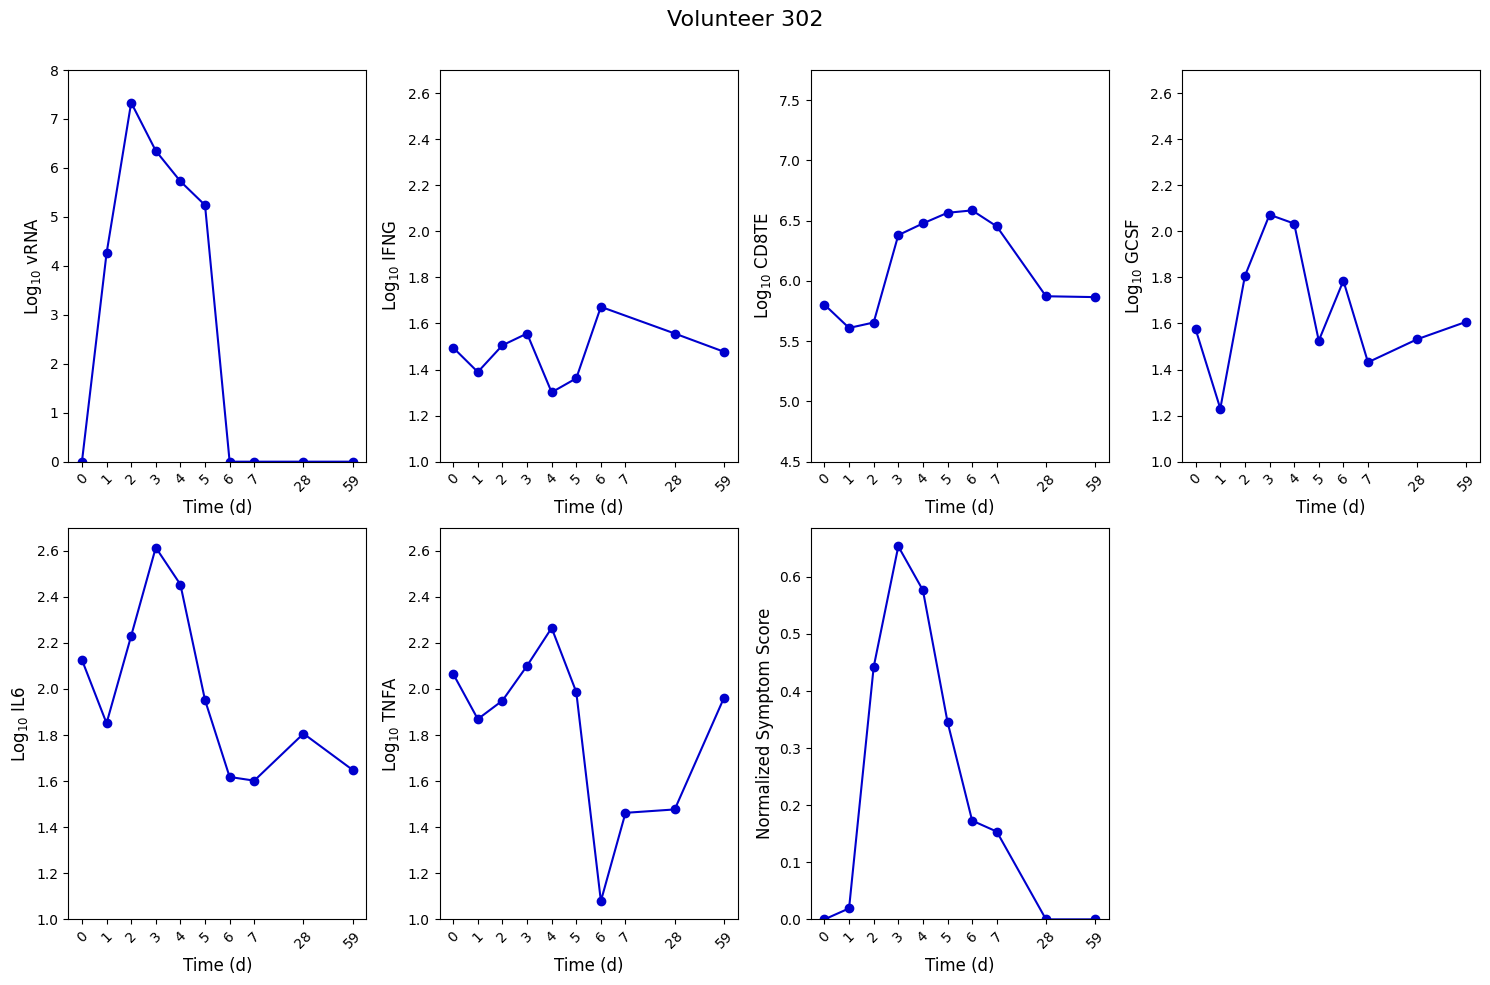

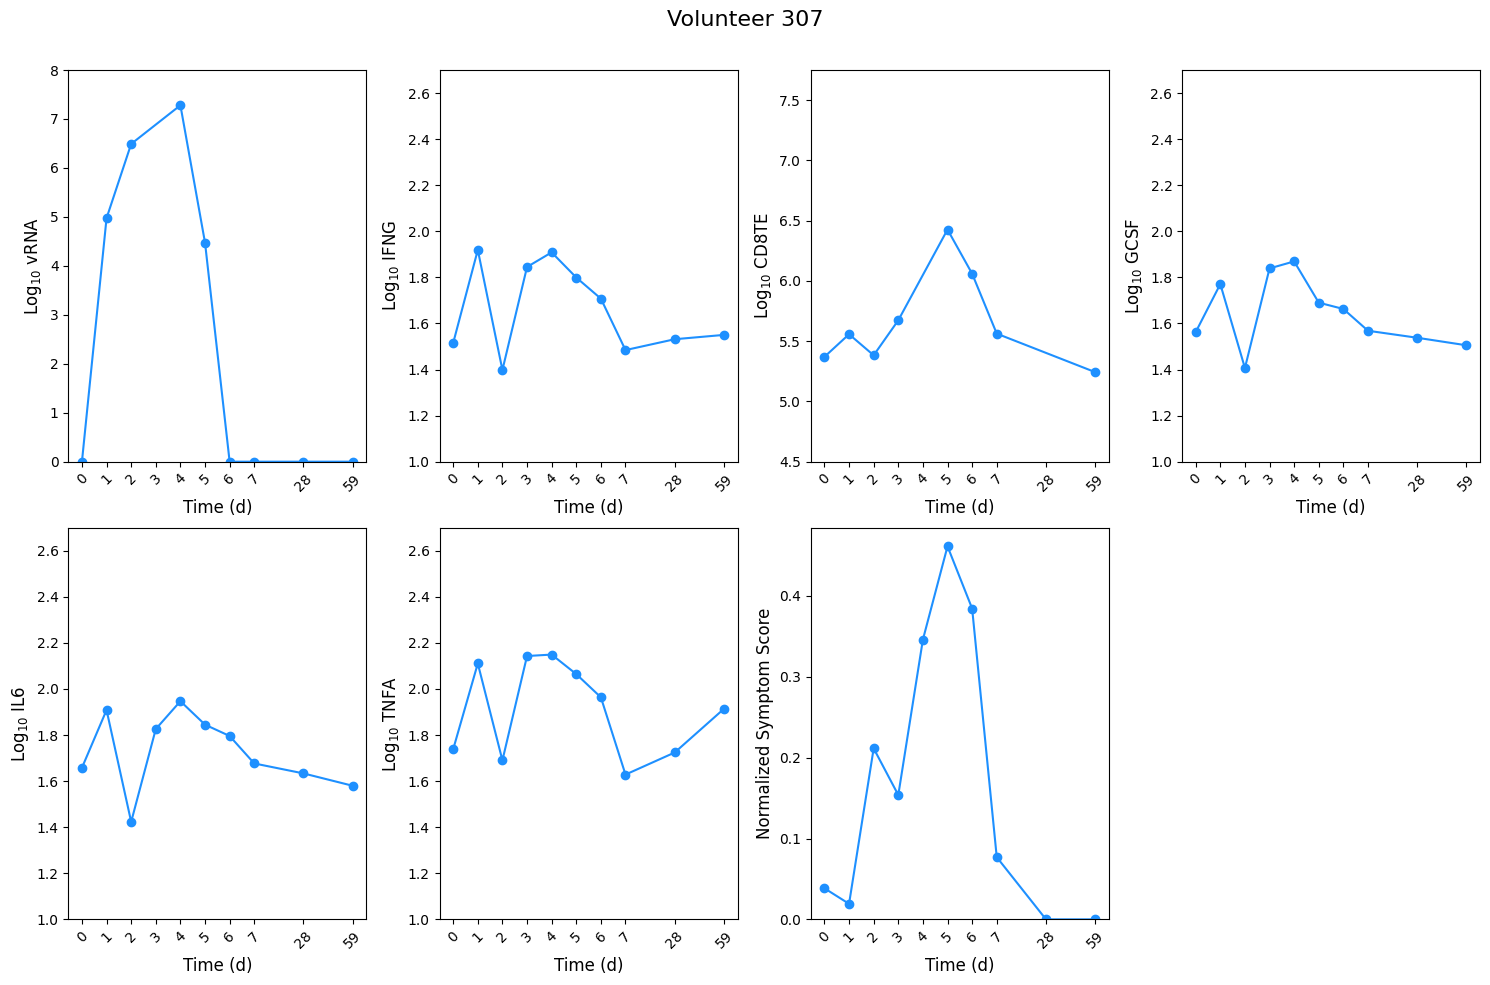

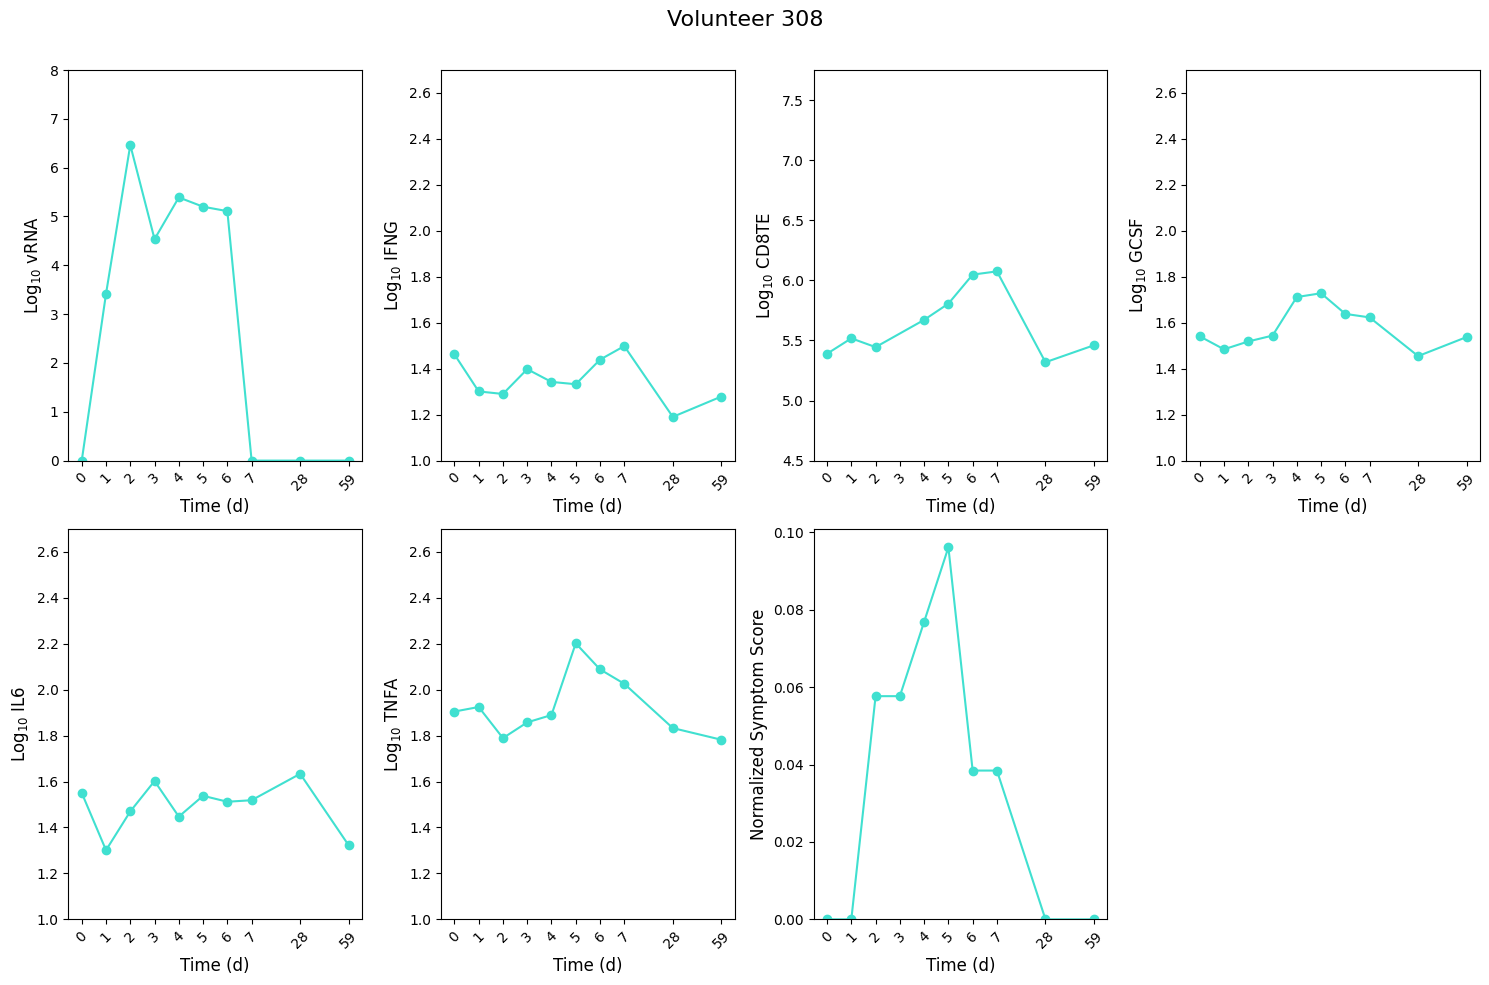

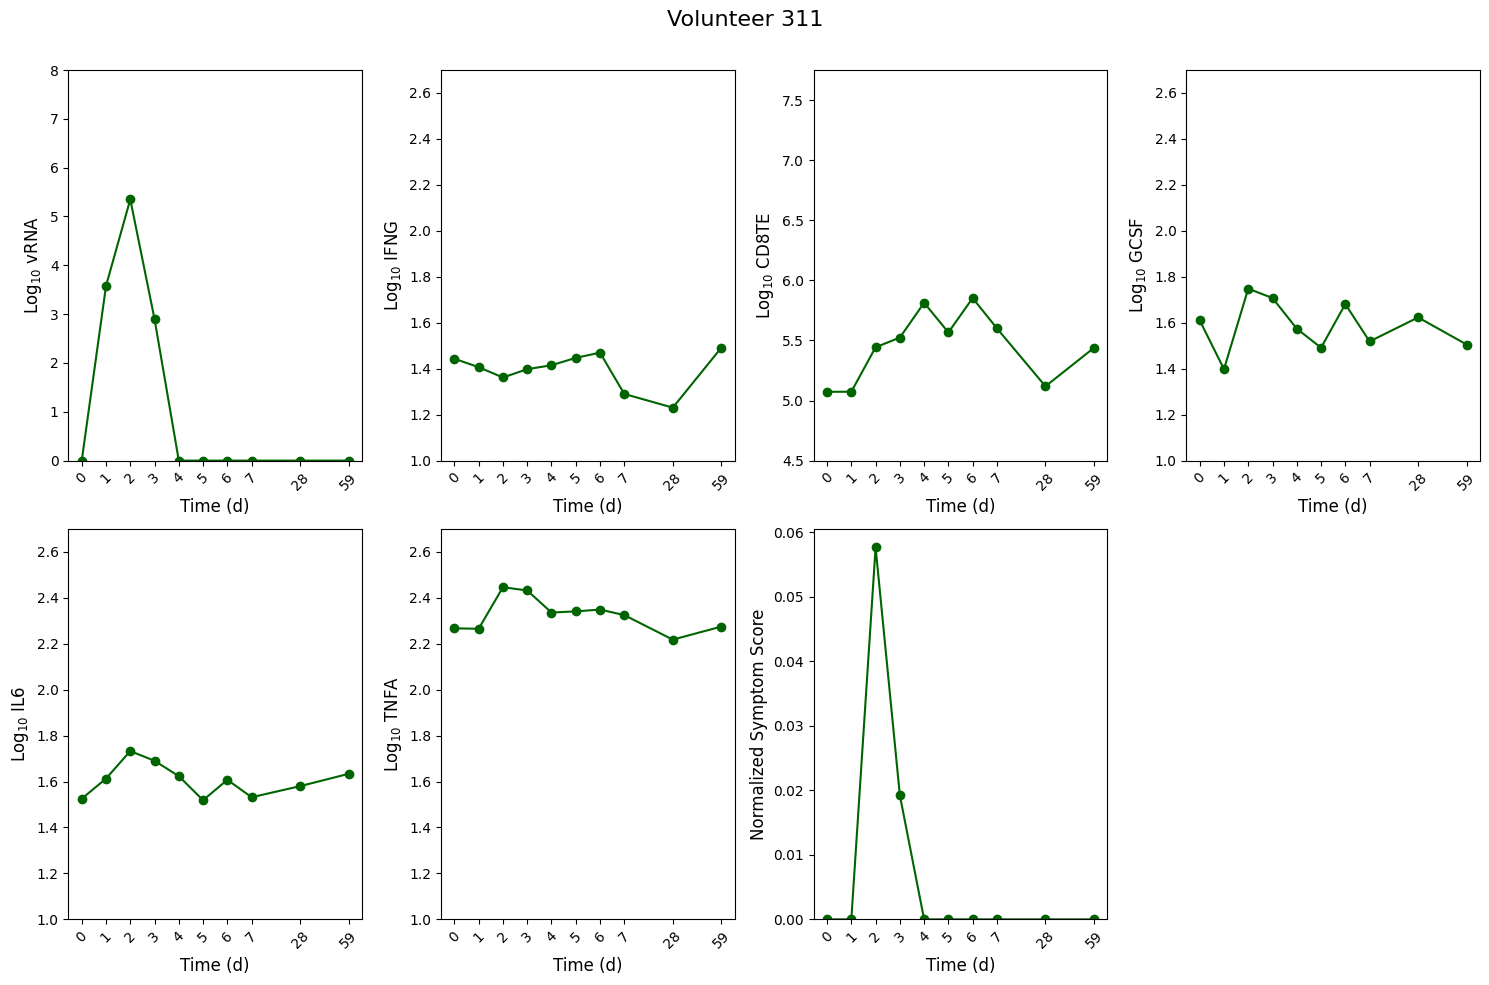

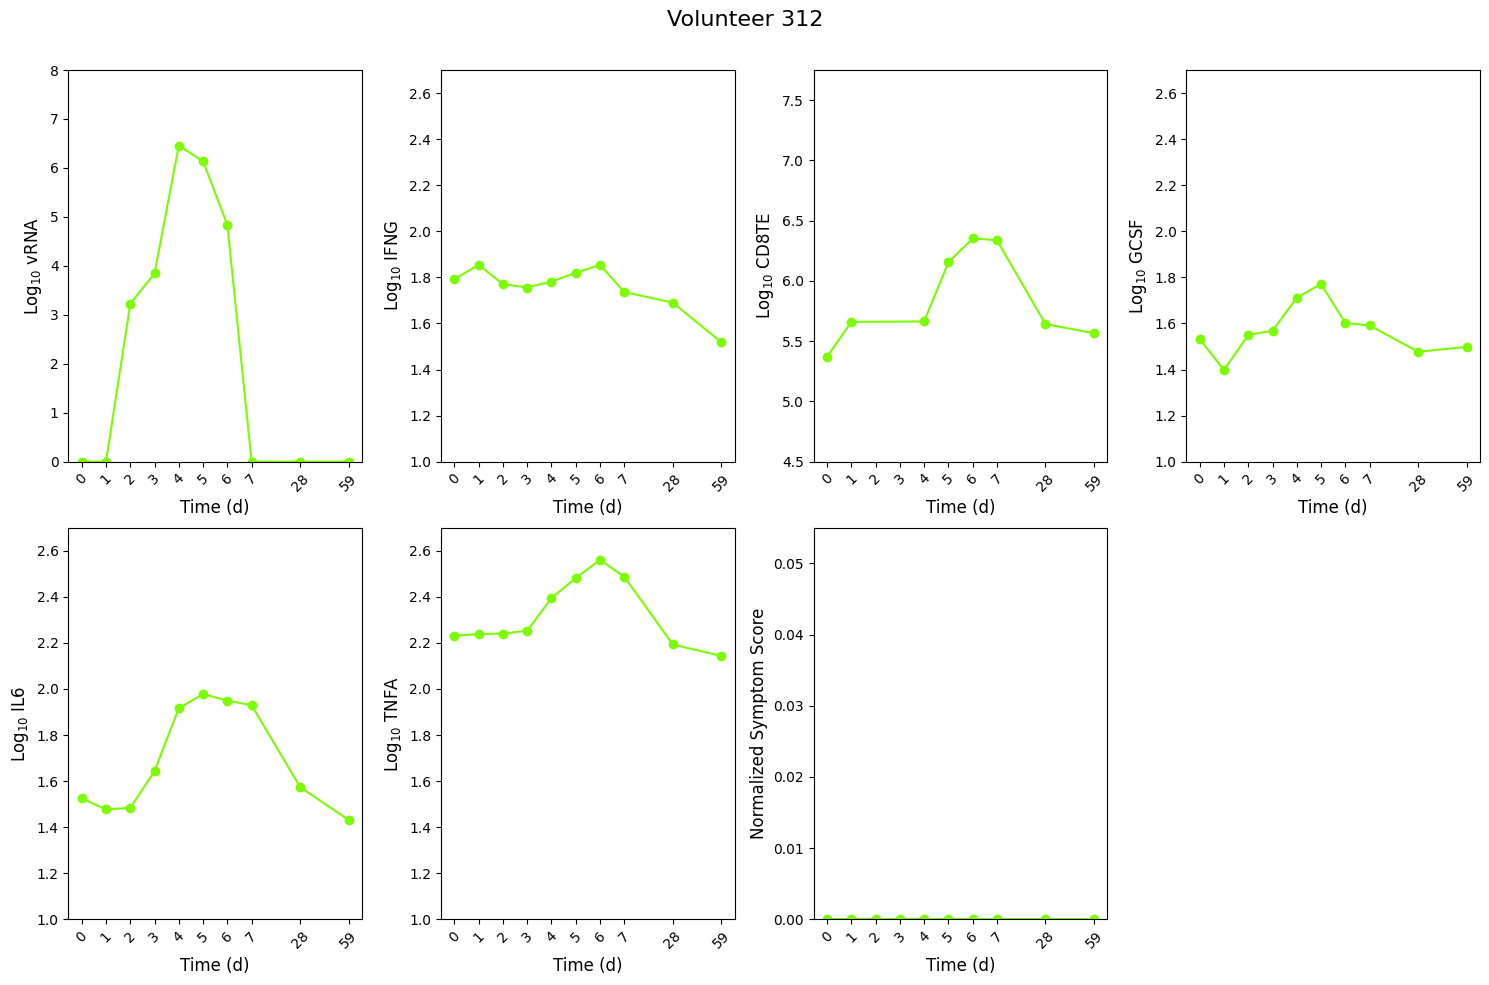

In [83]:
# Load Rahil data
df_Rahil = pd.read_excel("../Data/Rahil_2020/Table8_Healed.xlsx", sheet_name='NoTail', usecols=list(range(0, 143)))
df_Rahil = df_Rahil[['VOLUNTEER', 'DAY', 'V', 'IFNG', 'CD8TE', 'GCSF', 'IL6', 'TNFA', 'TSS']]
df_Rahil = df_Rahil.loc[df_Rahil['DAY'] < 60]
df_Rahil = df_Rahil.loc[df_Rahil['DAY'] >= 0]
shedders = [103, 107, 110, 111, 112, 204, 207, 302, 307, 308, 311, 312]
df_Rahil = df_Rahil[df_Rahil['VOLUNTEER'].isin(shedders)]
df_Rahil.columns = ['VOLUNTEER', 'DAY', 'vRNA', 'IFNG', 'CD8TE', 'GCSF', 'IL6', 'TNFA', 'TSS']
y_limits = {
    "CD8TE": (4.5, 7.75),
    "GCSF": (1, 2.7),
    "IFNG": (1, 2.7),
    "IL6": (1, 2.7),
    "TNFA": (1, 2.7),
    "vRNA": (0, 8),
}

autolimit = False

# Colors for patients (match color/id order)
patient_color_names = [
    'gray',
    'purple',
    'magenta',
    'red',
    'yellow',
    'darkorange',
    'saddlebrown',
    'mediumblue',
    'dodgerblue',
    'turquoise',
    'darkgreen',
    'lawngreen',
]
volunteer_colors = dict(zip(shedders, patient_color_names))
# Loop over each volunteer
for volunteer in shedders:
    # Create a figure with subplots
    fig, axes = plt.subplots(2, 4, figsize=(15, 10))
    axes = axes.flatten()
    color = volunteer_colors[volunteer]
    
    # Determine days_with_data across all states
    all_days_with_data = set()
    for state in states:
        state_data_rahil = df_Rahil[df_Rahil['VOLUNTEER'] == volunteer][['DAY', state]].copy()
        days_with_data_rahil = state_data_rahil['DAY'].unique()
        all_days_with_data.update(days_with_data_rahil)
    all_days_with_data = np.sort(list(all_days_with_data))
    
    # Abbreviate gaps in the x-axis by making it categorical
    x_positions = []
    x_pos = 0
    x_positions.append(x_pos)  # First position
    for i in range(1, len(all_days_with_data)):
        gap = all_days_with_data[i] - all_days_with_data[i - 1]
        if gap <= 10:
            x_pos += 1
        else:
            x_pos += 2  # Skip an extra position to represent large gaps
        x_positions.append(x_pos)
    day_to_xpos = dict(zip(all_days_with_data, x_positions))
    
    for idx, state in enumerate(states):
        ax = axes[idx]
        
        # Get Rahil data for this volunteer and state
        state_data_rahil = df_Rahil[df_Rahil['VOLUNTEER'] == volunteer][['DAY', state]].copy()
        
        # Drop any NaN values
        state_data_rahil = state_data_rahil.dropna(subset=[state])
        
        # Map day values to x positions
        state_data_rahil['xpos'] = state_data_rahil['DAY'].map(day_to_xpos)
        
        # Plot volunteer data, connecting scatter from day to day
        if state in log_states:
            ax.plot(
                state_data_rahil['xpos'],
                log10_floor(state_data_rahil[state]),
                marker='o',
                color=color,
                label=f"Volunteer {volunteer}"
            )
        else:
            ax.plot(
                state_data_rahil['xpos'],
                state_data_rahil[state],
                marker='o',
                color=color,
                label=f"Volunteer {volunteer}"
            )
        
        # Set labels, limits, etc.
        if autolimit:
            ax.set_ylim(auto=True)
            ax.set_yticks(ax.get_yticks().tolist() + [ax.get_ylim()[0], ax.get_ylim()[1]])
        else:
            ylim = y_limits.get(state, (0, None))
            ax.set_ylim(ylim)
        ax.set_xlabel("Time (d)", fontsize=12)
        if state in log_states:
            ylabstr = r"$\mathrm{Log}_{10}$ " + state 
        else:
            ylabstr = 'Normalized Symptom Score'
        ax.set_ylabel(ylabstr, fontsize=12)
        ax.tick_params(axis='both', which='major', labelsize=10)
        ax.grid(False)
        
        # Set x-ticks to match the categorical positions
        x_tick_positions = list(day_to_xpos.values())
        x_tick_labels = list(day_to_xpos.keys())
        ax.set_xticks(x_tick_positions)
        ax.set_xticklabels(x_tick_labels, rotation=45)
    
    # Remove any unused subplots
    if len(states) < len(axes):
        for idx in range(len(states), len(axes)):
            fig.delaxes(axes[idx])
            last_empty_ax = axes[idx]  # Save the last empty axis for legend placement

    # Plot a single legend in the last empty subplot
    handles, labels = axes[0].get_legend_handles_labels()
    if 'last_empty_ax' in locals():
        last_empty_ax.legend(handles, labels, loc='center', fontsize=10, ncol=2)
        last_empty_ax.axis('off')  # Turn off axis for the legend-only subplot

    plt.tight_layout()
    plt.suptitle(f"Volunteer {volunteer}", fontsize=16)
    plt.subplots_adjust(top=0.92)
    plt.show()
